# Octree Querying Practice

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

Let's work with a basic `Octree` structure in python and see how querying works within it. To keep things simple, we will start off in 2 dimensions and work our way up from there. Technically speaking, this data structure will now be called a `quadtree`.

In [167]:
# Create the base 2D space 10 x 10 dimensions
grid = np.zeros([10,10])
grid.shape

(10, 10)

In [168]:
# Create 20 random objects of random size and add them to the grid.
objects_dict = {}

for i in range (20):
    X = np.random.randint(0,9)
    Y = np.random.randint(0,9)
    
    objects_dict[i]=(X,Y)

    grid[X][Y] = 1

grid

array([[0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Now we create our `quadtree` implementation.

In [169]:
def make_quadtree(x_l, x_r, y_t, y_b, depth=3):
    """
    Docstring for make_quadtree
    
    :param depth: Description
    :input_grid: Description
    """
    quad_tree = {}
    
    if depth == 0:
        return quad_tree
    
    quad_tree['bounds'] = (x_l, x_r, y_t, y_b)
    quad_tree[0] = make_quadtree(x_l, x_r - (x_r - x_l)/2, y_t - (y_t - y_b)/2, y_b, depth-1)
    quad_tree[1] = make_quadtree(x_r - (x_r - x_l)/2, x_r, y_t - (y_t - y_b)/2, y_b, depth-1)
    quad_tree[2] = make_quadtree(x_l, x_r - (x_r - x_l)/2, y_t, y_t - (y_t - y_b)/2, depth-1)
    quad_tree[3] = make_quadtree(x_r - (x_r - x_l)/2, x_r, y_t, y_t - (y_t - y_b)/2, depth-1)

    return quad_tree


In [170]:
qt = make_quadtree(0,80,80,0, depth=5)
print(qt[2][0][0]['bounds'])

(0, 10.0, 50.0, 40.0)


In [171]:
def draw_rect(coords, ax, color, **kwargs):
    """
    Docstring for draw_rect
    
    :param coords: Description
    :param plt: Description
    """
    x_l, x_r, y_t, y_b = coords
    X = np.array([x_l, x_l, x_r, x_r, x_l])
    Y = np.array([y_t, y_b, y_b, y_t, y_t])
    
    ax.plot(X,Y, color=color, **kwargs)

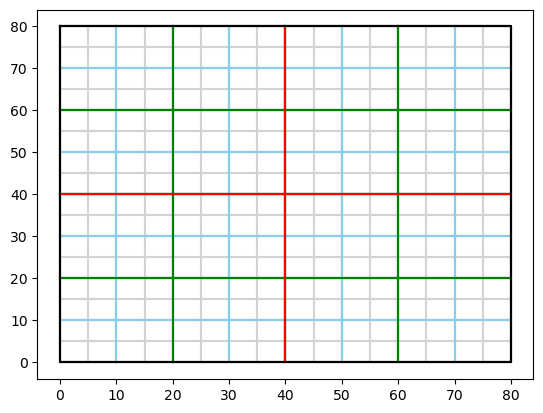

In [172]:
fig, ax = plt.subplots()

for i in range(4):
    for j in range(4):
        for k in range(4):
            for l in range(4):
                draw_rect(qt[i][j][k][l]['bounds'], ax, 'lightgrey')

for i in range(4):
    for j in range(4):
        for k in range(4):
            draw_rect(qt[i][j][k]['bounds'], ax, 'skyblue')

for i in range(4):
    for j in range(4):
        draw_rect(qt[i][j]['bounds'], ax, 'green')

for i in range(4):
    draw_rect(qt[i]['bounds'], ax, 'red')

draw_rect(qt['bounds'], ax, 'black')

plt.show()

In [173]:
def is_intersecting(pos: tuple, coords: tuple, threshold=5):
    """
    Docstring for is_intersecting
    
    :param pos: Description
    :type pos: tuple
    :param input_tree: Description
    :param threshold: Description
    """
    camera_x, camera_y = pos
    x_l, x_r, y_t, y_b = coords

    # Find where the camera is with reference to the box

    # Base case for if camera is within the box
    if (x_l < camera_x) & (camera_x < x_r) & (y_b < camera_y) & (camera_y < y_t):
        return True

    # find the X and Y coordinate of the nearest side of the box
    closest_x = max(x_l, min(camera_x, x_r))
    closest_y = max(y_b, min(camera_y, y_t))

    # find the length of the line from camera center to box edge
    curr_dist = (closest_x - camera_x)**2 + (closest_y - camera_y)**2
    
    if curr_dist < threshold**2:
        return True
    else:
        return False

In [174]:
# Create a color map for the different levels of the quadtree
color_map = {
    0: 'black',
    1: 'red',
    2: 'green',
    3: 'skyblue',
    4: 'lightgrey'
}

In [175]:
def draw_quadtree(pos:tuple, q_tree, threshold=5, level=0):
    """
    Docstring for draw_quadtree
    
    :param pos: Description
    :type pos: tuple
    :param q_tree: Description
    :param threshold: Description
    """
     
    if is_intersecting(pos, q_tree['bounds'], threshold):
        draw_rect(q_tree['bounds'], plt, color_map[level], zorder=5-level)
        try:
            draw_quadtree(pos, q_tree[0], threshold, level = level+1)
        except:
            return
        
        try:
            draw_quadtree(pos, q_tree[1], threshold, level = level+1)
        except:
            return

        try:
            draw_quadtree(pos, q_tree[2], threshold, level = level+1)
        except:
            return
        
        try:
            draw_quadtree(pos, q_tree[3], threshold, level = level+1)
        except:
            return

    return

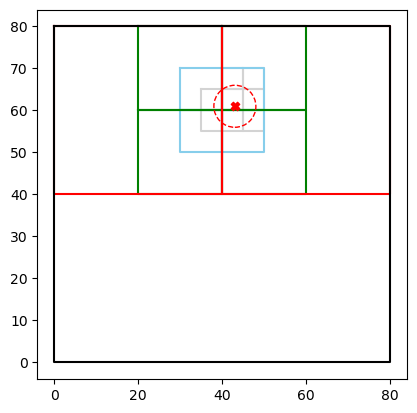

In [180]:
camera_pos = (43,61)
r=5

fig, ax = plt.subplots()

draw_quadtree(camera_pos, qt, threshold=r)

camera_x, camera_y = camera_pos
ax.scatter(camera_x,camera_y, marker='X', color='red', zorder=5)

circle = plt.Circle(camera_pos, r, color='red', fill=False, linestyle='--', zorder=5)
ax.add_patch(circle)

ax.set_aspect('equal')

plt.show()